In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [2]:
#定义变量 
thermal_power_station_strategy=np.zeros(shape=(4,1000)) 
wind_power_station_strategy=np.zeros(shape=(2,1000))
c_wind_speed= np.loadtxt("./data/c_wind_speed_uniform_distribution_(3,25).txt")      
kappa_wind_speed= np.loadtxt("./data/kappa_wind_speed_uniform_distribution_(2,3).txt")  
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(70,5).txt") #时变的需求侧用电需求  阶梯式变化 
thermal_power_station_dual_variable=np.zeros(shape=(4,1000))
wind_power_station_dual_variable=np.zeros(shape=(2,1000))#两个风力发电站中有一个是受到拜占庭攻击的 假设第二个风力发电站是受到攻击的
E=np.loadtxt("6_Network_Topology_Double_Random_Adjacency_Matrix.txt")
thermal_power_station_cost=np.zeros(shape=(1,1000)) #火力发电成本
wind_power_station_cost=np.zeros(shape=(1,1000)) #风力发电成本
sum_cost=np.zeros(shape=(1,1000)) #总发电成本
#thermal_power_station_eta=[0.0375,0.0375,0.0625,0.035]
thermal_power_station_eta=[0.0675,0.0675,0.0925,0.0625]
thermal_power_station_zeta=[2,1.75,1,3]
thermal_power_station_xi=[0,0,0,0]
thermal_power_station_P_min=[50,20,15,10]
thermal_power_station_P_max=[200,120,80,100]
#wind_power_station_varphi=[3,6]
wind_power_station_varphi=[1,6]
wind_power_station_v_in=[3,5]
wind_power_station_v_out=[25,25]
wind_power_station_v_r=[13,15]
wind_power_station_sigma_ue=[5,5]
wind_power_station_sigma_oe=[30,20]
wind_power_station_P_r=[160,160]
wind_power_station_P_min=[0,0]
wind_power_station_P_max=[160,160]
sum_thermal_wind_power_station_strategy=np.zeros(shape=(1,1000))
step_size_primal=1
step_size_dual=1
tau_robust1=np.zeros(shape=(6,1000))#每个用户在每次迭代中均需要计算出一个tau值
regularization_parameter=0.001
small_Gaussian_Byzantine_attack=np.loadtxt("./data/small_Gaussian_Byzantine_attack_(-150,5).txt")

In [3]:
#火力，风力发电策略初始化
thermal_power_station_strategy[0][0]=0
thermal_power_station_strategy[1][0]=0
thermal_power_station_strategy[2][0]=0
thermal_power_station_strategy[3][0]=0
wind_power_station_strategy[0][0]=0
wind_power_station_strategy[1][0]=0
#初始总发电策略
sum_thermal_wind_power_station_strategy[0][0]=0
#初始化受到攻击的风力发电站的对偶变量
wind_power_station_dual_variable[1][0]=small_Gaussian_Byzantine_attack[0]

#安全发电站的初始总发电成本
#火力发电成本
for i in range(0,4):
    thermal_power_station_cost[0][0]=thermal_power_station_cost[0][0]+thermal_power_station_eta[i]*thermal_power_station_strategy[i][0]*thermal_power_station_strategy[i][0]+thermal_power_station_zeta[i]*thermal_power_station_strategy[i][0]
#风力发电成本
for i in range(0,1):
    wind_power_station_cost[0][0]=wind_power_station_cost[0][0]+wind_power_station_varphi[i]*wind_power_station_strategy[i][0]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_r[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][0])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_in[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))
#发电总成本
sum_cost[0][0]=thermal_power_station_cost[0][0]+wind_power_station_cost[0][0]

#计算每个发电站的邻居发电站
neighbor_robust1_help=[]
for i in range (0,6):
    for j in range (0,6):
        if E[i][j]!=0:
            neighbor_robust1_help.append(j)
        elif E[i][j]==0:
            neighbor_robust1_help.append(99)
neighbor_robust1=np.array(neighbor_robust1_help).reshape(6,6)

#计算安全的发电站的拜占庭邻居用户数量
q_robust1=[]
for i in range(0,6):
    q_robust1_help=0
    for j in range(0,6):
        if neighbor_robust1[i][j]==5:
            q_robust1_help=q_robust1_help+1
    q_robust1.append(q_robust1_help)
    
#计算出5个诚实用户的邻居中有多少是诚实用户 有多少是拜占庭用户
neighbor_honest_num_robust1=[]
neighbor_byzantine_num_robust1=[]
for i in range(0,6):
    h_num_robust1=0
    b_num_robust1=0
    u_neighbor_help_robust1=neighbor_robust1[i].tolist()#将用户i的邻居序号存在辅助变量u中
    if i==0 or i==3 or i==4 or i==5:
        u_neighbor_help_robust1 = list(set(u_neighbor_help_robust1))
        u_neighbor_help_robust1.remove(99)
    u_neighbor_help_robust1.remove(i)
    for j in range(0,len(u_neighbor_help_robust1)):
        if u_neighbor_help_robust1[j]==5:
            b_num_robust1=b_num_robust1+1
        else:
            h_num_robust1=h_num_robust1+1
    neighbor_honest_num_robust1.append(h_num_robust1)
    neighbor_byzantine_num_robust1.append(b_num_robust1)

In [4]:
def SCC_Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,thermal_power_station_eta,thermal_power_station_zeta,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual):
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("***************************attack_free_online_decentralized_economic_dispatch*****************************")
    print("相关变量初始值为：")
    for i in range (0,4):
        print("第",(i+1),"个火力发电站的初始计划发电量为:",thermal_power_station_strategy[i][0])
    for i in range (0,2):
        print("第",(i+5),"个风力发电站的初始计划发电量为:",wind_power_station_strategy[i][0])
    print("****************************************************************************")
    for i in range (0,4):
        print("第",(i+1),"个火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[i][0])
    for i in range (0,1):
        print("第",(i+5),"个风力发电站的初始对偶变量为:",wind_power_station_dual_variable[i][0])
    print("****************************************************************************")
    print("第",(6),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[1][0])
    print("****************************************************************************")
    print("安全发电站的初始总发电量:",sum_thermal_wind_power_station_strategy[0][0])
    print("*************************")
    print("需求侧用电需求:",d_power_demand[0])
    print("****************************************************************************")
    print("风速分布参数c:",c_wind_speed[0])
    print("****************************************************************************")
    print("风速分布参数kappa:",kappa_wind_speed[0])
    print("****************************************************************************")
    print("安全发电站的总发电成本：", sum_cost[0][0])
    print("****************************************************************************")
    print("原变量迭代步长为:",step_size_primal)
    print("*****************************************************************************")
    print("对偶变量迭代步长为:",step_size_dual)
    print("*****************************************************************************")
    
    #开始迭代
    for k in range(1,1000):
        #发电站更新计划发电量和对偶变量
        #对偶变量 先做梯度上升 再做聚合
        #安全发电站的梯度上升
        dual_variable_intermediate=[] #存放当前迭代中6个用户对对偶变量做完梯度下降后得到的中间值
        for i in range(0,4):
            dual_variable_intermediate.append(thermal_power_station_dual_variable[i][k-1]+step_size_dual*((1/6)*thermal_power_station_strategy[i][k-1]-(1/6)*d_power_demand[k-1]-regularization_parameter*thermal_power_station_dual_variable[i][k-1]))
        for j in range(0,1):
            dual_variable_intermediate.append(wind_power_station_dual_variable[j][k-1]+step_size_dual*((1/6)*wind_power_station_strategy[j][k-1]-(1/6)*d_power_demand[k-1]-regularization_parameter*wind_power_station_dual_variable[j][k-1]))
        #受到攻击的风力发电站的对偶值
        dual_variable_intermediate.append(wind_power_station_dual_variable[1][k-1])
        
        #SCC鲁棒聚合 安全的火力发电站的对偶更新
        for i in range (0,4):
            c_clipping_dual_robust1=[]#存放当前诚实用户对邻居的对偶变量裁剪后的值
            mix_sum_c_dual_robust1=0#存放clipping后的对偶值和
            u_neighbor_help_robust1=neighbor_robust1[i].tolist()#将用户i的邻居序号存在辅助变量u中
            if i==0 or i==3:
                u_neighbor_help_robust1 = list(set(u_neighbor_help_robust1))
                u_neighbor_help_robust1.remove(99)
            u_neighbor_help_robust1.remove(i)
            #计算用户i在当前阶段的tau值
            if neighbor_byzantine_num_robust1[i]==0:
                tau_robust1[i][k]=10000
            else:
                weight_sum_robust1=0
                for j in range(0,len(u_neighbor_help_robust1)):
                    if u_neighbor_help_robust1[j]!=5:
                        weight_sum_robust1=weight_sum_robust1+E[i][u_neighbor_help_robust1[j]]*(dual_variable_intermediate[u_neighbor_help_robust1[j]]-dual_variable_intermediate[i])*(dual_variable_intermediate[u_neighbor_help_robust1[j]]-dual_variable_intermediate[i])
                tau_robust1[i][k]=sqrt(weight_sum_robust1/(E[i][5]))                       
            #每个诚实用户首先对邻居传来的对偶变量进行剪裁clipping
            for j in range (0, len(u_neighbor_help_robust1)): #问题：分母会出现0的情况
                if (dual_variable_intermediate[u_neighbor_help_robust1[j]]-dual_variable_intermediate[i])==0:
                    c_clipping_dual_robust1.append(0)
                elif 1<=(tau_robust1[i][k]/(abs((dual_variable_intermediate[u_neighbor_help_robust1[j]]-dual_variable_intermediate[i])))):
                    c_clipping_dual_robust1.append(dual_variable_intermediate[u_neighbor_help_robust1[j]]-dual_variable_intermediate[i])
                else:
                    c_clipping_dual_robust1.append((dual_variable_intermediate[u_neighbor_help_robust1[j]]-dual_variable_intermediate[i])*((tau_robust1[i][k]/(abs((dual_variable_intermediate[u_neighbor_help_robust1[j]]-dual_variable_intermediate[i]))))))    
            #诚实用户聚合clipping后的邻居对偶值和自身的对偶值 
            for j in range(0,len(u_neighbor_help_robust1)):
                mix_sum_c_dual_robust1=mix_sum_c_dual_robust1+E[i][u_neighbor_help_robust1[j]]*(dual_variable_intermediate[i]+c_clipping_dual_robust1[j])
            #诚实用户基于SCC鲁棒聚合后的值进行自身的对偶变量的更新
            thermal_power_station_dual_variable[i][k]=E[i][i]*dual_variable_intermediate[i]+mix_sum_c_dual_robust1
        
        #聚合 安全的风力发电站的对偶更新 由于其邻居中没有拜占庭用户 所以直接按权重聚合即可
        for j in range(0,6):
            wind_power_station_dual_variable[0][k]=wind_power_station_dual_variable[0][k]+E[4][j]*dual_variable_intermediate[j]          

        #受到Byzantine攻击的风力发电站的对偶更新
        wind_power_station_dual_variable[1][k]=small_Gaussian_Byzantine_attack[k]           
        
        #安全的火力发电站计划发电量
        for i in range(0,4):
            thermal_power_station_strategy[i][k]=thermal_power_station_strategy[i][k-1]-step_size_primal*(2*thermal_power_station_eta[i]*thermal_power_station_strategy[i][k-1]+thermal_power_station_zeta[i]+(1/6)*thermal_power_station_dual_variable[i][k-1]) 
            if thermal_power_station_strategy[i][k]<=thermal_power_station_P_min[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_min[i]
            elif thermal_power_station_strategy[i][k]>=thermal_power_station_P_max[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_max[i]
        #安全的风力发电站计划发电量
        for i in range(0,1):
            wind_power_station_strategy[i][k]=wind_power_station_strategy[i][k-1]-step_size_primal*(wind_power_station_varphi[i]+wind_power_station_sigma_oe[i]+(wind_power_station_sigma_ue[i]+wind_power_station_sigma_oe[i])*math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(-wind_power_station_sigma_ue[i]-wind_power_station_sigma_oe[i])*math.exp(-(math.pow((wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k-1])/wind_power_station_P_r[i]),kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(1/6)*wind_power_station_dual_variable[i][k-1])
            if wind_power_station_strategy[i][k]<=wind_power_station_P_min[i]:
                wind_power_station_strategy[i][k]=wind_power_station_P_min[i]
            elif wind_power_station_strategy[i][k]>=wind_power_station_P_max[i]:
                wind_power_station_strategy[i][k]=wind_power_station_P_max[i]
        #受到Byzantine攻击的风力发电站的计划发电量
        wind_power_station_strategy[1][k]=wind_power_station_strategy[1][k-1]
        
        #安全发电站的计算总计划发电
        #火力发电量
        for i in range(0,4):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+thermal_power_station_strategy[i][k]
        #风力发电量
        for i in range(0,1):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+wind_power_station_strategy[i][k]
        
        #安全发电站的计算总发电成本
        #火力发电成本
        for i in range(0,4):
            thermal_power_station_cost[0][k]=thermal_power_station_cost[0][k]+thermal_power_station_eta[i]*thermal_power_station_strategy[i][k]*thermal_power_station_strategy[i][k]+thermal_power_station_zeta[i]*thermal_power_station_strategy[i][k]
        #风力发电成本
        for i in range(0,1):
            wind_power_station_cost[0][k]=wind_power_station_cost[0][k]+wind_power_station_varphi[i]*wind_power_station_strategy[i][k]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_r[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][k])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_in[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))
        #发电总成本
        sum_cost[0][k]=thermal_power_station_cost[0][k]+wind_power_station_cost[0][k]
        
        #输出第k次迭代中的结果 每间隔10次迭代输出一次结果
        #if (k+1)%10==0:
        print(k,"次迭代中的结果：")
        for i in range (0,4):
            print("第",(i+1),"个火力发电站的计划发电量为:",thermal_power_station_strategy[i][k])
        for i in range (0,2):
            print("第",(i+5),"个风力发电站的计划发电量为:",wind_power_station_strategy[i][k])
        print("****************************************************************************")
        for i in range (0,4):
            print("第",(i+1),"个火力发电站的对偶变量为:",thermal_power_station_dual_variable[i][k])
        for i in range (0,1):
            print("第",(i+5),"个风力发电站的对偶变量为:",wind_power_station_dual_variable[i][k])
        print("****************************************************************************")
        print("第",(6),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[1][k])
        print("****************************************************************************")
        print("安全发电站的总发电量:",sum_thermal_wind_power_station_strategy[0][k])
        print("*************************")
        print("需求侧用电需求:",d_power_demand[k])
        print("****************************************************************************")
        print("风速分布参数c:",c_wind_speed[k])
        print("****************************************************************************")
        print("风速分布参数kappa:",kappa_wind_speed[k])
        print("****************************************************************************")        
        print("安全发电站的总发电成本：", sum_cost[0][k])
        print("****************************************************************************")
        print("原变量迭代步长为:",step_size_primal)
        print("****************************************************************************")
        print("对偶变量迭代步长为:",step_size_dual)
        print("****************************************************************************")

    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])
    return None  

In [5]:
SCC_Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,thermal_power_station_eta,thermal_power_station_zeta,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual)

***************************attack_free_online_decentralized_economic_dispatch*****************************
相关变量初始值为：
第 1 个火力发电站的初始计划发电量为: 0.0
第 2 个火力发电站的初始计划发电量为: 0.0
第 3 个火力发电站的初始计划发电量为: 0.0
第 4 个火力发电站的初始计划发电量为: 0.0
第 5 个风力发电站的初始计划发电量为: 0.0
第 6 个风力发电站的初始计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的初始对偶变量为: 0.0
第 2 个火力发电站的初始对偶变量为: 0.0
第 3 个火力发电站的初始对偶变量为: 0.0
第 4 个火力发电站的初始对偶变量为: 0.0
第 5 个风力发电站的初始对偶变量为: 0.0
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -149.59297205
****************************************************************************
安全发电站的初始总发电量: 0.0
*************************
需求侧用电需求: 72.62781256
****************************************************************************
风速分布参数c: 8.301041
****************************************************************************
风速分布参数kappa: 2.66836324
**************************************************************************

对偶变量迭代步长为: 1
****************************************************************************
26 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 90.20390803304511
第 2 个火力发电站的计划发电量为: 92.31857297618261
第 3 个火力发电站的计划发电量为: 73.46005552543893
第 4 个火力发电站的计划发电量为: 89.92461637874635
第 5 个风力发电站的计划发电量为: 73.38768464350177
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -78.2119973550831
第 2 个火力发电站的对偶变量为: -78.9607310232584
第 3 个火力发电站的对偶变量为: -79.55547274860045
第 4 个火力发电站的对偶变量为: -78.10135845208877
第 5 个风力发电站的对偶变量为: -78.50465856462776
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -155.52368054
****************************************************************************
安全发电站的总发电量: 419.29483755691473
*************************
需求侧用电需求: 76.57534104
****************************************************************************
风速分布参数c: 11.11125981
*****************************************************

风速分布参数kappa: 2.65936912
****************************************************************************
安全发电站的总发电成本： 2452.8155056917412
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
45 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 68.41314681259114
第 2 个火力发电站的计划发电量为: 72.5080999611912
第 3 个火力发电站的计划发电量为: 56.87560208173312
第 4 个火力发电站的计划发电量为: 70.0969892840658
第 5 个风力发电站的计划发电量为: 78.78136326255431
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -65.73817132079876
第 2 个火力发电站的对偶变量为: -67.92901419236404
第 3 个火力发电站的对偶变量为: -69.0917370735931
第 4 个火力发电站的对偶变量为: -69.37662209446182
第 5 个风力发电站的对偶变量为: -65.63165204739009
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -145.69625775
********

第 3 个火力发电站的计划发电量为: 58.829227766336274
第 4 个火力发电站的计划发电量为: 73.19134756674251
第 5 个风力发电站的计划发电量为: 109.44310835600811
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -62.5757254837868
第 2 个火力发电站的对偶变量为: -66.51241276769231
第 3 个火力发电站的对偶变量为: -67.71310016702202
第 4 个火力发电站的对偶变量为: -68.62074057258734
第 5 个风力发电站的对偶变量为: -62.16492022755652
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -157.80483469
****************************************************************************
安全发电站的总发电量: 384.6200455909013
*************************
需求侧用电需求: 74.55388328
****************************************************************************
风速分布参数c: 19.39127935
****************************************************************************
风速分布参数kappa: 2.20652383
****************************************************************************
安全发电站的总发电成本： 3015.8698697033137
*****************

第 2 个火力发电站的对偶变量为: -76.0917559116728
第 3 个火力发电站的对偶变量为: -77.15786790764976
第 4 个火力发电站的对偶变量为: -77.16837304957066
第 5 个风力发电站的对偶变量为: -74.45027836294352
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -142.77966237
****************************************************************************
安全发电站的总发电量: 361.7836394637926
*************************
需求侧用电需求: 66.9462126
****************************************************************************
风速分布参数c: 16.49128078
****************************************************************************
风速分布参数kappa: 2.53722773
****************************************************************************
安全发电站的总发电成本： 2638.8929411385916
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
96 次迭代中的结果：


第 3 个火力发电站的计划发电量为: 58.50222117378114
第 4 个火力发电站的计划发电量为: 70.35523348213933
第 5 个风力发电站的计划发电量为: 48.00055623636163
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -72.62455354947717
第 2 个火力发电站的对偶变量为: -73.24510706717086
第 3 个火力发电站的对偶变量为: -73.74651935368406
第 4 个火力发电站的对偶变量为: -72.72105186474292
第 5 个风力发电站的对偶变量为: -72.81244651543537
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -153.41171976
****************************************************************************
安全发电站的总发电量: 320.8625021037734
*************************
需求侧用电需求: 68.13334167
****************************************************************************
风速分布参数c: 3.26289987
****************************************************************************
风速分布参数kappa: 2.46100087
****************************************************************************
安全发电站的总发电成本： 3136.1794955897
**********************

安全发电站的总发电成本： 2762.043117105753
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
141 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 74.26878034873401
第 2 个火力发电站的计划发电量为: 77.55413909501108
第 3 个火力发电站的计划发电量为: 60.972166986246734
第 4 个火力发电站的计划发电量为: 74.56130103995469
第 5 个风力发电站的计划发电量为: 66.61567734262802
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -70.19980470342105
第 2 个火力发电站的对偶变量为: -71.16876742905654
第 3 个火力发电站的对偶变量为: -71.87741449644972
第 4 个火力发电站的对偶变量为: -71.23018770774593
第 5 个风力发电站的对偶变量为: -70.39114408536035
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -146.64131097
****************************************************************************
安全发电站的总发电量: 353.972064812574

安全发电站的总发电成本： 2978.060588178878
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
162 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 77.56167159307628
第 2 个火力发电站的计划发电量为: 80.38473530955696
第 3 个火力发电站的计划发电量为: 64.11169679647206
第 4 个火力发电站的计划发电量为: 76.53756250209378
第 5 个风力发电站的计划发电量为: 91.99460064305673
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -75.69232912472205
第 2 个火力发电站的对偶变量为: -77.32263672350591
第 3 个火力发电站的对偶变量为: -78.42758146405961
第 4 个火力发电站的对偶变量为: -78.25710882198075
第 5 个风力发电站的对偶变量为: -75.51641213810409
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -156.2955612
****************************************************************************
安全发电站的总发电量: 390.5902668442558


第 1 个火力发电站的计划发电量为: 72.25121860498572
第 2 个火力发电站的计划发电量为: 76.89586856019578
第 3 个火力发电站的计划发电量为: 60.70731558024778
第 4 个火力发电站的计划发电量为: 74.84086235702719
第 5 个风力发电站的计划发电量为: 107.6677367744813
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -67.3561551028566
第 2 个火力发电站的对偶变量为: -70.59038711085081
第 3 个火力发电站的对偶变量为: -71.80921877178643
第 4 个火力发电站的对偶变量为: -72.26592243171362
第 5 个风力发电站的对偶变量为: -66.98968867655107
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -157.42223112
****************************************************************************
安全发电站的总发电量: 392.36300187693774
*************************
需求侧用电需求: 73.91637131
****************************************************************************
风速分布参数c: 3.64353585
****************************************************************************
风速分布参数kappa: 2.10726954
******************************************************

第 4 个火力发电站的计划发电量为: 71.23075513077106
第 5 个风力发电站的计划发电量为: 98.30413786554921
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -70.84068733555392
第 2 个火力发电站的对偶变量为: -72.97122031091011
第 3 个火力发电站的对偶变量为: -74.07034112964205
第 4 个火力发电站的对偶变量为: -74.2332278061817
第 5 个风力发电站的对偶变量为: -70.62188083176969
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -155.45500156
****************************************************************************
安全发电站的总发电量: 373.28935993369095
*************************
需求侧用电需求: 76.34795428
****************************************************************************
风速分布参数c: 14.39442675
****************************************************************************
风速分布参数kappa: 2.96340634
****************************************************************************
安全发电站的总发电成本： 2463.205730188556
********************************************************

第 2 个火力发电站的计划发电量为: 72.89008016161154
第 3 个火力发电站的计划发电量为: 57.79307589243774
第 4 个火力发电站的计划发电量为: 71.00435392934813
第 5 个风力发电站的计划发电量为: 93.5473442282665
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -63.55483100151776
第 2 个火力发电站的对偶变量为: -66.58198293780524
第 3 个火力发电站的对偶变量为: -67.72520468150346
第 4 个火力发电站的对偶变量为: -68.31677857636618
第 5 个风力发电站的对偶变量为: -63.30825147940372
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -152.37963724
****************************************************************************
安全发电站的总发电量: 362.4811952082571
*************************
需求侧用电需求: 72.28672624
****************************************************************************
风速分布参数c: 24.98297969
****************************************************************************
风速分布参数kappa: 2.34107593
****************************************************************************
安全发电站的总发电成本： 3

第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -158.52952579
****************************************************************************
安全发电站的总发电量: 370.5236226783496
*************************
需求侧用电需求: 67.79107025
****************************************************************************
风速分布参数c: 11.4269651
****************************************************************************
风速分布参数kappa: 2.84267716
****************************************************************************
安全发电站的总发电成本： 2683.637798052774
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
251 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 76.53585184397113
第 2 个火力发电站的计划发电量为: 79.64998895708354
第 3 个火力发电站的计划发电量为: 63.62332580468513
第 4 个火力发电站的计划发电量为: 76.28146024809234
第 5 个风力发电站的计划发电量为: 83.01346392177479
第 6 个风力发电站的计划发电量为: 0.0
****************

第 4 个火力发电站的计划发电量为: 73.20418449849724
第 5 个风力发电站的计划发电量为: 96.45829323423462
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -66.0683113836039
第 2 个火力发电站的对偶变量为: -70.10102923545672
第 3 个火力发电站的对偶变量为: -71.25840523957858
第 4 个火力发电站的对偶变量为: -72.29114535566015
第 5 个风力发电站的对偶变量为: -65.71552140003224
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -150.03110487
****************************************************************************
安全发电站的总发电量: 372.8250289859225
*************************
需求侧用电需求: 59.41836689
****************************************************************************
风速分布参数c: 15.70487747
****************************************************************************
风速分布参数kappa: 2.98740162
****************************************************************************
安全发电站的总发电成本： 2469.159089986423
*********************************************************

第 4 个火力发电站的计划发电量为: 73.88276585046879
第 5 个风力发电站的计划发电量为: 68.81372027122333
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -74.08678658055463
第 2 个火力发电站的对偶变量为: -75.12118172381655
第 3 个火力发电站的对偶变量为: -76.06383481677653
第 4 个火力发电站的对偶变量为: -75.6952022038625
第 5 个风力发电站的对偶变量为: -74.04772864947002
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -152.41154576
****************************************************************************
安全发电站的总发电量: 353.8925288429838
*************************
需求侧用电需求: 66.42137964
****************************************************************************
风速分布参数c: 9.67729724
****************************************************************************
风速分布参数kappa: 2.2861422
****************************************************************************
安全发电站的总发电成本： 2689.1740887328474
**********************************************************

对偶变量迭代步长为: 1
****************************************************************************
312 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 80.01827556029131
第 2 个火力发电站的计划发电量为: 82.75345494901669
第 3 个火力发电站的计划发电量为: 65.50583117285026
第 4 个火力发电站的计划发电量为: 78.69897223428428
第 5 个风力发电站的计划发电量为: 76.51835939641475
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -77.1220612459174
第 2 个火力发电站的对偶变量为: -77.53363477485912
第 3 个火力发电站的对偶变量为: -78.25970409021629
第 4 个火力发电站的对偶变量为: -76.99856557456728
第 5 个风力发电站的对偶变量为: -77.23712940652166
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -151.88353491
****************************************************************************
安全发电站的总发电量: 383.49489331285724
*************************
需求侧用电需求: 69.41981789
****************************************************************************
风速分布参数c: 19.34908088
***************************************************

****************************************************************************
风速分布参数c: 3.19736338
****************************************************************************
风速分布参数kappa: 2.358826
****************************************************************************
安全发电站的总发电成本： 3972.1243801388996
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
339 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 68.41089745708993
第 2 个火力发电站的计划发电量为: 73.23640249227094
第 3 个火力发电站的计划发电量为: 58.09281595814555
第 4 个火力发电站的计划发电量为: 71.1215299237248
第 5 个风力发电站的计划发电量为: 55.90558719059812
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -69.55336846534794
第 2 个火力发电站的对偶变量为: -71.17592130969187
第 3 个火力发电站的对偶变量为: -72.21931252346997
第 4 个火力发电站的对偶变量为: -72.298468363

第 2 个火力发电站的对偶变量为: -77.43060181433412
第 3 个火力发电站的对偶变量为: -78.08697921458854
第 4 个火力发电站的对偶变量为: -77.11664940825395
第 5 个风力发电站的对偶变量为: -76.85550355416513
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -152.97074076
****************************************************************************
安全发电站的总发电量: 373.3217286929964
*************************
需求侧用电需求: 60.84033172
****************************************************************************
风速分布参数c: 24.5308053
****************************************************************************
风速分布参数kappa: 2.22707408
****************************************************************************
安全发电站的总发电成本： 3348.9980898251233
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
366 次迭代中的结果

第 5 个风力发电站的对偶变量为: -65.83918472611344
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -150.34523019
****************************************************************************
安全发电站的总发电量: 377.3209003000776
*************************
需求侧用电需求: 70.91012053
****************************************************************************
风速分布参数c: 21.90328039
****************************************************************************
风速分布参数kappa: 2.02990755
****************************************************************************
安全发电站的总发电成本： 3212.2602845999136
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
390 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 67.8945814476091
第 2 个火力发电站的计划发电量为: 73.38133093444776
第 3 个火力发电站的计划发电量为: 58.2473683267216

****************************************************************************
410 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 69.3746056663919
第 2 个火力发电站的计划发电量为: 74.80299354962963
第 3 个火力发电站的计划发电量为: 59.63835172619055
第 4 个火力发电站的计划发电量为: 72.86510150201886
第 5 个风力发电站的计划发电量为: 75.17017180931428
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -69.58765258452803
第 2 个火力发电站的对偶变量为: -71.14893302683359
第 3 个火力发电站的对偶变量为: -72.20330638340836
第 4 个火力发电站的对偶变量为: -72.20532338888533
第 5 个风力发电站的对偶变量为: -69.53338248943889
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -153.86014321
****************************************************************************
安全发电站的总发电量: 351.8512242535452
*************************
需求侧用电需求: 74.81009654
****************************************************************************
风速分布参数c: 5.34265522
******************************************************************

第 5 个风力发电站的对偶变量为: -68.59472436441541
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -151.56872057
****************************************************************************
安全发电站的总发电量: 383.67649816321426
*************************
需求侧用电需求: 69.39661248
****************************************************************************
风速分布参数c: 4.00348291
****************************************************************************
风速分布参数kappa: 2.33870845
****************************************************************************
安全发电站的总发电成本： 4552.3743795697455
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
432 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 72.95366817444787
第 2 个火力发电站的计划发电量为: 77.54462807503849
第 3 个火力发电站的计划发电量为: 61.598745176636

****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -150.16122288
****************************************************************************
安全发电站的总发电量: 364.45808556647376
*************************
需求侧用电需求: 67.05431856
****************************************************************************
风速分布参数c: 16.18987363
****************************************************************************
风速分布参数kappa: 2.16705395
****************************************************************************
安全发电站的总发电成本： 2664.8291652562734
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
452 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 68.74646320503973
第 2 个火力发电站的计划发电量为: 73.44908374481282
第 3 个火力发电站的计划发电量为: 58.62138130251276
第 4 个火力发电站的计划发电量为: 71.16053810379

第 1 个火力发电站的对偶变量为: -73.02353007762827
第 2 个火力发电站的对偶变量为: -74.15984171991208
第 3 个火力发电站的对偶变量为: -75.05203584353015
第 4 个火力发电站的对偶变量为: -74.82102419639894
第 5 个风力发电站的对偶变量为: -73.08801883254979
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -149.46933743
****************************************************************************
安全发电站的总发电量: 359.5586622727251
*************************
需求侧用电需求: 72.88872624
****************************************************************************
风速分布参数c: 18.60221604
****************************************************************************
风速分布参数kappa: 2.74439199
****************************************************************************
安全发电站的总发电成本： 2761.525769207179
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
***************************************************

第 1 个火力发电站的计划发电量为: 70.30019391097115
第 2 个火力发电站的计划发电量为: 74.33708042297602
第 3 个火力发电站的计划发电量为: 58.87749482482488
第 4 个火力发电站的计划发电量为: 71.82867841913813
第 5 个风力发电站的计划发电量为: 82.56764272877811
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -68.7857994326468
第 2 个火力发电站的对偶变量为: -70.52319834075227
第 3 个火力发电站的对偶变量为: -71.61899281647332
第 4 个火力发电站的对偶变量为: -71.41755771972718
第 5 个风力发电站的对偶变量为: -68.55645842994124
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -141.86382252
****************************************************************************
安全发电站的总发电量: 357.91109030668827
*************************
需求侧用电需求: 75.978379
****************************************************************************
风速分布参数c: 15.172168
****************************************************************************
风速分布参数kappa: 2.55880292
*********************************************************

第 5 个风力发电站的计划发电量为: 80.58271818779161
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -67.7627174295138
第 2 个火力发电站的对偶变量为: -69.4614333601963
第 3 个火力发电站的对偶变量为: -70.58245663351155
第 4 个火力发电站的对偶变量为: -70.45188749698491
第 5 个风力发电站的对偶变量为: -67.59259229960239
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -147.24470344
****************************************************************************
安全发电站的总发电量: 367.8252386914083
*************************
需求侧用电需求: 75.1706157
****************************************************************************
风速分布参数c: 11.31709967
****************************************************************************
风速分布参数kappa: 2.69968848
****************************************************************************
安全发电站的总发电成本： 2654.507586410308
****************************************************************************
原变量迭代步长为: 1
*******

第 2 个火力发电站的计划发电量为: 75.23485259856352
第 3 个火力发电站的计划发电量为: 59.79627231818322
第 4 个火力发电站的计划发电量为: 72.39391873616896
第 5 个风力发电站的计划发电量为: 65.64676987477533
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -70.39439342664379
第 2 个火力发电站的对偶变量为: -72.58502032742052
第 3 个火力发电站的对偶变量为: -73.69732148155812
第 4 个火力发电站的对偶变量为: -74.04169431544653
第 5 个风力发电站的对偶变量为: -70.2684704593282
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -153.10706588
****************************************************************************
安全发电站的总发电量: 344.368945892809
*************************
需求侧用电需求: 67.69616936
****************************************************************************
风速分布参数c: 10.17858689
****************************************************************************
风速分布参数kappa: 2.7809508
****************************************************************************
安全发电站的总发电成本： 247

第 3 个火力发电站的对偶变量为: -75.2229112904
第 4 个火力发电站的对偶变量为: -75.23441102809193
第 5 个风力发电站的对偶变量为: -72.14434293803681
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -151.62656479
****************************************************************************
安全发电站的总发电量: 376.74056304382304
*************************
需求侧用电需求: 65.16052839
****************************************************************************
风速分布参数c: 7.48945921
****************************************************************************
风速分布参数kappa: 2.68190889
****************************************************************************
安全发电站的总发电成本： 3266.594544928158
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
584 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 72.406470938906
第 2 

第 2 个火力发电站的对偶变量为: -72.31195016294495
第 3 个火力发电站的对偶变量为: -73.47449287710718
第 4 个火力发电站的对偶变量为: -74.0748252316686
第 5 个风力发电站的对偶变量为: -68.94163158714397
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -147.80599791
****************************************************************************
安全发电站的总发电量: 373.38787658019
*************************
需求侧用电需求: 60.77952139
****************************************************************************
风速分布参数c: 7.65995367
****************************************************************************
风速分布参数kappa: 2.49922595
****************************************************************************
安全发电站的总发电成本： 3261.3180585253363
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
606 次迭代中的结果：
第

第 4 个火力发电站的计划发电量为: 76.93493082336175
第 5 个风力发电站的计划发电量为: 102.62421594291165
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -72.07038697888402
第 2 个火力发电站的对偶变量为: -74.15050939117614
第 3 个火力发电站的对偶变量为: -75.3281301656389
第 4 个火力发电站的对偶变量为: -75.31804271535526
第 5 个风力发电站的对偶变量为: -71.84661055799356
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -149.33375697
****************************************************************************
安全发电站的总发电量: 398.1431160168747
*************************
需求侧用电需求: 73.50040448
****************************************************************************
风速分布参数c: 15.36683227
****************************************************************************
风速分布参数kappa: 2.89415795
****************************************************************************
安全发电站的总发电成本： 2739.7338961398573
*******************************************************

第 2 个火力发电站的对偶变量为: -68.9125693034442
第 3 个火力发电站的对偶变量为: -70.0431176347337
第 4 个火力发电站的对偶变量为: -70.31152419848863
第 5 个风力发电站的对偶变量为: -66.27615728272711
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -157.63267929
****************************************************************************
安全发电站的总发电量: 363.2590326515449
*************************
需求侧用电需求: 70.2009548
****************************************************************************
风速分布参数c: 11.80872925
****************************************************************************
风速分布参数kappa: 2.11948424
****************************************************************************
安全发电站的总发电成本： 2694.434489110199
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
652 次迭代中的结果：
第

安全发电站的总发电量: 404.9099473275429
*************************
需求侧用电需求: 71.95239731
****************************************************************************
风速分布参数c: 16.71848286
****************************************************************************
风速分布参数kappa: 2.5126964
****************************************************************************
安全发电站的总发电成本： 2966.7590127112144
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
674 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 74.41088783477
第 2 个火力发电站的计划发电量为: 80.31045409060718
第 3 个火力发电站的计划发电量为: 63.364716680338844
第 4 个火力发电站的计划发电量为: 78.70375853032127
第 5 个风力发电站的计划发电量为: 110.29079254257132
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -66.77118473660727
第 2 个火力发电站的对偶变量为: -71.0655

*************************
需求侧用电需求: 77.34219498
****************************************************************************
风速分布参数c: 6.40518525
****************************************************************************
风速分布参数kappa: 2.41086848
****************************************************************************
安全发电站的总发电成本： 3208.4692625088205
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
694 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 71.7888272980815
第 2 个火力发电站的计划发电量为: 75.7712392117169
第 3 个火力发电站的计划发电量为: 60.709451582772736
第 4 个火力发电站的计划发电量为: 72.9833950259467
第 5 个风力发电站的计划发电量为: 67.5438826603054
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -76.15054057264642
第 2 个火力发电站的对偶变量为: -77.139754413936
第 3 个火力发电站的对偶变量为: -78.0

第 4 个火力发电站的对偶变量为: -77.18830526217138
第 5 个风力发电站的对偶变量为: -74.6870145228574
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -141.74182689
****************************************************************************
安全发电站的总发电量: 397.16567384841665
*************************
需求侧用电需求: 71.54494544
****************************************************************************
风速分布参数c: 15.83605088
****************************************************************************
风速分布参数kappa: 2.79430191
****************************************************************************
安全发电站的总发电成本： 2824.6936771289566
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
714 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 77.74562463338738
第 2 个火力发电站的计划发电量为: 81.175165345534

第 4 个火力发电站的对偶变量为: -75.64496543027342
第 5 个风力发电站的对偶变量为: -76.6295186663672
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -150.25358406
****************************************************************************
安全发电站的总发电量: 342.82034833098675
*************************
需求侧用电需求: 71.25505354
****************************************************************************
风速分布参数c: 19.55214918
****************************************************************************
风速分布参数kappa: 2.1566782
****************************************************************************
安全发电站的总发电成本： 2788.069150298992
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
737 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 74.78603127870268
第 2 个火力发电站的计划发电量为: 77.72325378163525

风速分布参数kappa: 2.57732605
****************************************************************************
安全发电站的总发电成本： 2488.252869004196
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
765 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 68.41188241704405
第 2 个火力发电站的计划发电量为: 71.83449747326259
第 3 个火力发电站的计划发电量为: 56.9452747458925
第 4 个火力发电站的计划发电量为: 68.49104914861458
第 5 个风力发电站的计划发电量为: 44.99787639107257
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -69.98582768509296
第 2 个火力发电站的对偶变量为: -70.57602384888445
第 3 个火力发电站的对偶变量为: -70.77579082389762
第 4 个火力发电站的对偶变量为: -69.19728661101064
第 5 个风力发电站的对偶变量为: -70.32200272771851
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -147.7665244
*******

第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -67.59727367694592
第 2 个火力发电站的对偶变量为: -68.59125681754519
第 3 个火力发电站的对偶变量为: -69.51516937903389
第 4 个火力发电站的对偶变量为: -69.01130076219806
第 5 个风力发电站的对偶变量为: -67.66188679465677
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -147.18685623
****************************************************************************
安全发电站的总发电量: 355.766960192148
*************************
需求侧用电需求: 65.85020005
****************************************************************************
风速分布参数c: 15.12736853
****************************************************************************
风速分布参数kappa: 2.98276951
****************************************************************************
安全发电站的总发电成本： 2591.3599724003516
****************************************************************************
原变量迭代步长为: 1
*****************************************

第 5 个风力发电站的计划发电量为: 92.40895926957856
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -76.07750934284508
第 2 个火力发电站的对偶变量为: -77.40371955445269
第 3 个火力发电站的对偶变量为: -78.47831672671342
第 4 个火力发电站的对偶变量为: -78.16695429560886
第 5 个风力发电站的对偶变量为: -75.96300821416017
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -155.2275588
****************************************************************************
安全发电站的总发电量: 398.2610400137935
*************************
需求侧用电需求: 74.79426155
****************************************************************************
风速分布参数c: 16.00304837
****************************************************************************
风速分布参数kappa: 2.47141071
****************************************************************************
安全发电站的总发电成本： 2962.805763410426
****************************************************************************
原变量迭代步长为: 1
*****

第 3 个火力发电站的计划发电量为: 55.77179011526441
第 4 个火力发电站的计划发电量为: 69.04943554490549
第 5 个风力发电站的计划发电量为: 105.08970962534751
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -65.0041288035349
第 2 个火力发电站的对偶变量为: -68.34720229208202
第 3 个火力发电站的对偶变量为: -69.4816855937318
第 4 个火力发电站的对偶变量为: -69.90427168288647
第 5 个风力发电站的对偶变量为: -64.56581653953374
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -143.82291077
****************************************************************************
安全发电站的总发电量: 365.4248762791874
*************************
需求侧用电需求: 74.24335424
****************************************************************************
风速分布参数c: 6.48944104
****************************************************************************
风速分布参数kappa: 2.44768213
****************************************************************************
安全发电站的总发电成本： 3651.544275706045
*********************

安全发电站的总发电量: 352.96137514449754
*************************
需求侧用电需求: 58.19306424
****************************************************************************
风速分布参数c: 24.59085333
****************************************************************************
风速分布参数kappa: 2.59111266
****************************************************************************
安全发电站的总发电成本： 3053.579177862879
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
868 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 66.0391353352807
第 2 个火力发电站的计划发电量为: 71.81061810230155
第 3 个火力发电站的计划发电量为: 57.386587123046255
第 4 个火力发电站的计划发电量为: 69.77385998350091
第 5 个风力发电站的计划发电量为: 90.04320741770832
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -66.22429221031024
第 2 个火力发电站的对偶变量为: -69.14

****************************************************************************
886 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 75.05563199827215
第 2 个火力发电站的计划发电量为: 78.49220633913455
第 3 个火力发电站的计划发电量为: 62.61149362204454
第 4 个火力发电站的计划发电量为: 75.41333891763003
第 5 个风力发电站的计划发电量为: 78.14620153975667
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -71.87576297775337
第 2 个火力发电站的对偶变量为: -73.46317798187401
第 3 个火力发电站的对偶变量为: -74.54375080820876
第 4 个火力发电站的对偶变量为: -74.46570976667837
第 5 个风力发电站的对偶变量为: -71.74967088824887
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -154.85015789
****************************************************************************
安全发电站的总发电量: 369.71887241683794
*************************
需求侧用电需求: 68.19035828
****************************************************************************
风速分布参数c: 9.99529554
****************************************************************

905 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 68.39310174476651
第 2 个火力发电站的计划发电量为: 74.1838756976845
第 3 个火力发电站的计划发电量为: 58.70554938429942
第 4 个火力发电站的计划发电量为: 72.54625413268005
第 5 个风力发电站的计划发电量为: 82.04969848005702
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -66.80498862916788
第 2 个火力发电站的对偶变量为: -68.85255770621434
第 3 个火力发电站的对偶变量为: -69.98063740058672
第 4 个火力发电站的对偶变量为: -70.21373768372808
第 5 个风力发电站的对偶变量为: -66.70230689368935
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -143.6338674
****************************************************************************
安全发电站的总发电量: 355.8784794394875
*************************
需求侧用电需求: 65.26473893
****************************************************************************
风速分布参数c: 10.98816331
****************************************************************************
风速分布参数kappa: 2.95947097
******************************************

第 1 个火力发电站的计划发电量为: 72.46033547302761
第 2 个火力发电站的计划发电量为: 76.15045224615342
第 3 个火力发电站的计划发电量为: 60.688204351687865
第 4 个火力发电站的计划发电量为: 73.18275530546666
第 5 个风力发电站的计划发电量为: 60.139478658036566
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -74.22578369515077
第 2 个火力发电站的对偶变量为: -74.99965916176295
第 3 个火力发电站的对偶变量为: -75.88965094313309
第 4 个火力发电站的对偶变量为: -75.26370800081637
第 5 个风力发电站的对偶变量为: -74.21297223202653
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -150.945037
****************************************************************************
安全发电站的总发电量: 342.6212260343721
*************************
需求侧用电需求: 70.88564198
****************************************************************************
风速分布参数c: 8.32011436
****************************************************************************
风速分布参数kappa: 2.38448273
******************************************************

956 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 74.5982050403939
第 2 个火力发电站的计划发电量为: 78.64522249582191
第 3 个火力发电站的计划发电量为: 62.347528846370224
第 4 个火力发电站的计划发电量为: 76.36604255417978
第 5 个风力发电站的计划发电量为: 90.42336247970597
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -71.98480169556979
第 2 个火力发电站的对偶变量为: -73.29491226910508
第 3 个火力发电站的对偶变量为: -74.38875669398045
第 4 个火力发电站的对偶变量为: -74.00413011136747
第 5 个风力发电站的对偶变量为: -71.86110137815791
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -149.44545166
****************************************************************************
安全发电站的总发电量: 382.3803614164718
*************************
需求侧用电需求: 72.52881724
****************************************************************************
风速分布参数c: 5.85455319
****************************************************************************
风速分布参数kappa: 2.1109125
******************************************

第 4 个火力发电站的计划发电量为: 78.27025652809749
第 5 个风力发电站的计划发电量为: 78.3136769112897
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -78.32444700932942
第 2 个火力发电站的对偶变量为: -78.94785101770945
第 3 个火力发电站的对偶变量为: -79.76823154014883
第 4 个火力发电站的对偶变量为: -78.82931553877623
第 5 个风力发电站的对偶变量为: -78.3990288059968
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -154.83293851
****************************************************************************
安全发电站的总发电量: 385.3541538317961
*************************
需求侧用电需求: 69.49133351
****************************************************************************
风速分布参数c: 11.82837734
****************************************************************************
风速分布参数kappa: 2.5563993
****************************************************************************
安全发电站的总发电成本： 2895.4369842956494
**********************************************************

In [6]:
#数据存储
np.savetxt('./data/04_SCC_optimal_parameters_small_Gaussian_Byzantine_attack_sum_cost.txt',sum_cost,fmt='%0.8f')
np.savetxt('./data/04_SCC_optimal_parameters_small_Gaussian_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt',sum_thermal_wind_power_station_strategy,fmt='%0.8f')

In [7]:
#评价指标：动态regret和累计的约束违反

In [8]:
#动态regret

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [10]:
sum_cost=np.loadtxt("./data/04_SCC_optimal_parameters_small_Gaussian_Byzantine_attack_sum_cost.txt")
optimal_sum_cost=np.loadtxt("./data/00_optimal_sum_cost_varying_D_c_kappa_normal_distribution_(70,5).txt")

In [11]:
dynamic_regret=[]
dynamic_regret_T=[]
for T in range(1, 1000):
    dynamic_regret_auxiliary_variable=0
    for t in range(0, T):
        dynamic_regret_auxiliary_variable=dynamic_regret_auxiliary_variable+sum_cost[t+1]-optimal_sum_cost[t+1]
    dynamic_regret.append(dynamic_regret_auxiliary_variable)
    dynamic_regret_T.append((dynamic_regret_auxiliary_variable)/T)

In [12]:
dynamic_regret_T

[-1203.6743223,
 -1458.1681773,
 -1589.6554169233332,
 -1522.617072225,
 -1545.8889986059999,
 -1491.939234195,
 -1485.42125273,
 -1425.360851405,
 -1353.2735766899998,
 -1399.4079975089999,
 -1355.4010644518182,
 -1245.5804185258332,
 -1167.3196382576923,
 -1077.4598792771428,
 -956.0454241133333,
 -858.83164701125,
 -755.0622533,
 -625.6876906955555,
 -521.0431544384211,
 -432.72639736250005,
 -356.6926567433334,
 -251.21112756545455,
 -193.3554794373913,
 -126.49630506458332,
 -64.24080750039998,
 -38.48366890999999,
 -20.031231276666656,
 14.42711942285715,
 42.228218280689646,
 78.27523323899999,
 104.0453115583871,
 113.5546229178125,
 125.57786420090909,
 136.37775512352943,
 168.64303131600002,
 180.15386230638893,
 183.89837376972974,
 209.8646874489474,
 223.40381116153853,
 234.06471137575008,
 237.32497717146353,
 231.99518975500013,
 249.90840105651174,
 247.95535800363643,
 247.3437099533334,
 248.77075710478263,
 266.02121696042553,
 263.00496188666665,
 256.475522791428

In [13]:
#绘图 dynamic_regret和dynamic_regret_T

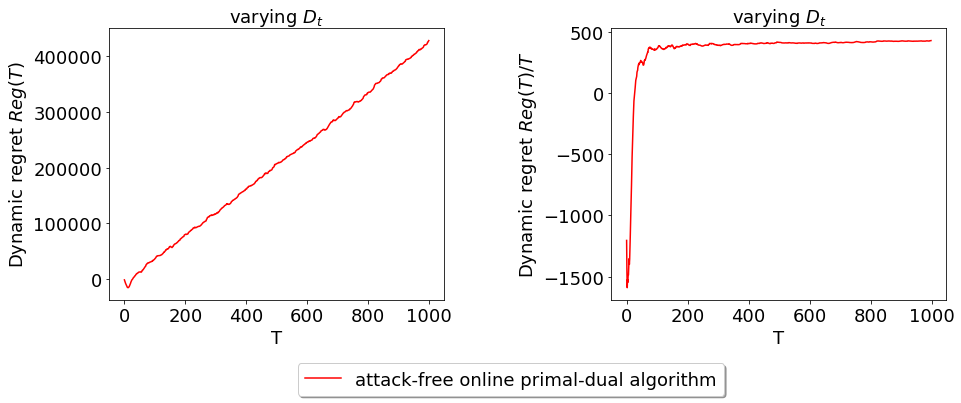

In [14]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret,color = 'red',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret_T,color = 'red',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))

#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.png',format='png', bbox_inches='tight')

In [15]:
#累计的约束违反

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [17]:
sum_thermal_wind_power_station_strategy=np.loadtxt("./data/04_SCC_optimal_parameters_small_Gaussian_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt")
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(70,5).txt")

In [18]:
accumulative_constraint_violation=[]
accumulative_constraint_violation_T=[]
for T in range(1, 1000):
    accumulative_constraint_violation_auxiliary_variable=0
    for t in range(0, T): 
        accumulative_constraint_violation_auxiliary_variable=accumulative_constraint_violation_auxiliary_variable+(1/5)*sum_thermal_wind_power_station_strategy[t+1]-d_power_demand[t+1]
    accumulative_constraint_violation.append(abs(accumulative_constraint_violation_auxiliary_variable))
    accumulative_constraint_violation_T.append(abs(accumulative_constraint_violation_auxiliary_variable)/T)

In [19]:
accumulative_constraint_violation_T

[44.659041904000006,
 48.588688235000006,
 50.17187312533334,
 50.5269115015,
 49.8808214904,
 48.762567708333336,
 47.48856498800001,
 44.845898918,
 42.74765415777778,
 42.0206582558,
 40.42686813072728,
 37.47903203933334,
 35.0290672903077,
 32.72693842542858,
 29.863709972400002,
 27.391548011250006,
 25.35176851058824,
 23.378914212,
 20.979872097052635,
 19.181498298900003,
 17.597070116380955,
 16.05391464236364,
 14.7347370766087,
 13.707979832166671,
 12.292383573520006,
 11.539460110230776,
 10.93255449355556,
 10.041034875357147,
 9.372323616689659,
 8.57746914626667,
 7.8398430278709705,
 7.619248834125003,
 7.161101021818185,
 6.764097215882356,
 6.197343925200003,
 5.809502785777781,
 5.517002615783787,
 4.800554949315793,
 4.432285581641029,
 4.250604215250003,
 4.049932857073174,
 4.114600618333337,
 4.018827266186049,
 3.865629744727275,
 3.749694720177781,
 3.5884500011739164,
 3.5315932120851095,
 3.4434185200416696,
 3.504697105428574,
 3.5094770283600023,
 3.48754

In [20]:
#绘图 accumulative_constraint_violation和accumulative_constraint_violation_T

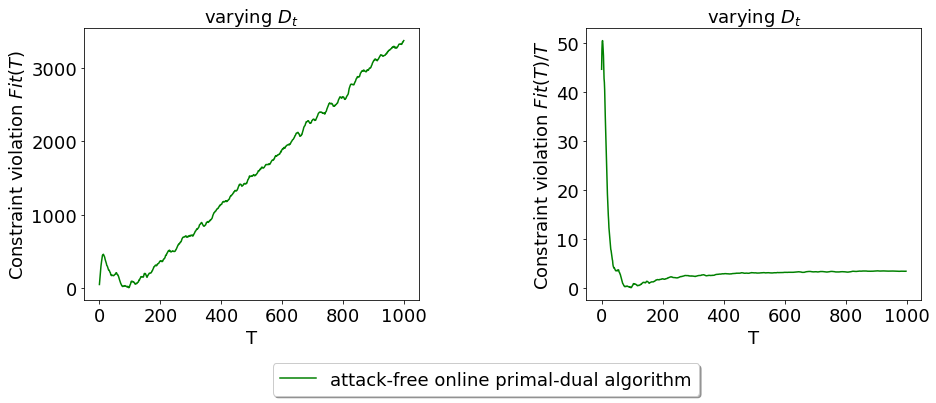

In [21]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation_T,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))


#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.png',format='png', bbox_inches='tight')